<div style="text-align: right"> Albíter Alpízar Vicente </div>
<div style="text-align: right"> Aprendizaje Computacional: Tarea 3 </div>
<div style="text-align: right"> 12/04/2019 </div>


## Problema 1

En primer lugar, importaremos las librerías de python que usaremos a lo largo del código. Las librerías _pandas_ y _numpy_ se usarán a lo largo de todos los problemas como librerías de utilidad general para manejar y operar con tablas/matrices/vectores. La librería _matplotlib_ se usará para graficar los resultados obtenidos. Por su parte, _PolynomialFeatures_ y _KFold_ se usarán sólo en lugares específicos de este problema.  

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

In [28]:
data = pd.read_csv("housing.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


A continuación, separamos la tabla de datos obtenida en una matriz de atributos $X_t$ (que corresponde a todas menos la última columna de la tabla obtenida del archivo _housing_) y un vector de etiquetas $Y_t$ (que corresponde a la última columna de la misma tabla de datos).

In [13]:
houses = data.values
X = houses[:, :-1]
Y = houses[:, -1:]
X[1]

array([2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
       6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
       1.7800e+01, 3.9690e+02, 9.1400e+00])

### Definición de funciones importantes

Antes de entrenar a nuestro modelo, definiremos las funciones más importantes con las que trabajaremos a lo largo de este problema. En primer lugar, importaremos las clases _LinearRegression_, _Lasso_ y _Ridge_ de la librería _sklearn_ para construir nuestras regresiones lineales según Mínimos Cuadrados, Mínimos Cuadrados con regularización L1, y Mínimos Cuadrados con regularización L2, respectivamente.

In [14]:
# Scikit-learn Lasso (L1) and Ridge (L2) functions for LS linear regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

Los modelos que buscaremos entrenar a lo largo de este problema harán uso de funciones base de tipo polinomial. Para poder construir y comparar modelos distintos con base en nuestra matriz de atributos $X_t$, haremos expansiones polinomiales de esta matriz, con la función _polynomial-expansion_, mostrada a continuación. En esencia, esta función toma como parámetros a una matriz de _n_ atributos $X$, un grado $d$, y construye una nueva matriz de $nd$ atributos $X'$, tal que esta nueva matriz es una concatenación de todas las potencias de la matriz $X$ con grado menor o igual que $d$. Esto es, $X' = [X X^{2}X^{3}...X^{d}]$. Esta expansión es una simplificación de una expansión polinomial completa, pues no considera los términos cruzados entre atributos distintos (sólo considera las potencias de los atributos mismos), no obstante, será suficiente para el propósito de este problema.

In [15]:
# Returns a polynomial expansion of the input-matrix X
def polynomial_expansion(X, degree):
    phi_X = X
    for i in range(degree - 1):
        powerX = np.power(X, i + 2)
        phi_X = np.column_stack((phi_X, powerX))
    return phi_X

Para entrenar a nuestros modelos de regresión lineal, utilizaremos un estimador de máxima verosimilitud. Dicho estimador se encarga de encontrar los parámetros $\theta\$ tales que, si $Y$ es nuestro vector de etiquetas de entrada, y $Y = f(X, \theta)$, donde $Y$ es un "vector de predicciones", estos parámetros minimizan el error que existe entre las etiquetas de entrenamiento y las predicciones hechas por el modelo.

El estimador en cuestión tiene una forma de solución cerrada, y ésta es precisamente la solución a la ecuación de _Mínimos Cuadrados_. Esto es, es posible obtener a nuestro vector de parámetros $\theta$ utilizando:

$$\theta = (X^{T}X)^{-1}X^{T}Y$$

La función _lsq_ (definida abajo), hace precisamente esto: toma a una matriz de atributos $X_t$, un vector de etiquetas de entrenamiento $Y_t$, un grado $d$, realiza una expansión polinomial de esta matriz tal y como se definió arriba, y obtiene la solución a la ecuación de mínimos cuadrados recién planteada.

In [16]:
# Performs a linear regression over the training set Xt/Yt using LS without regularization
def lsq(Xt, Yt, degree):
    Xt = polynomial_expansion(Xt, degree)
    clf = LinearRegression()
    linreg = clf.fit(Xt, Yt)
    return np.column_stack((linreg.intercept_, linreg.coef_)).T

Las funciones _regularized-lsq-l1_ y _regularized-lsq-l2_, realizan el mismo procedimiento, pero utilizando una versión distinta del estimador descrito anteriormente. La característica principal de estas nuevas ecuaciones es que éstas usan un término extra, denominado $\lambda$ y conocido como el "término de regularización". Este término pretende hacer una especie de "re-pesado" de parámetros, de manera que el modelo obtenido no tenga _overfit_ (condición en la cual un modelo de regresión lineal se adapta perfectamente a los datos de entrenamiento, pero se comporta pobremente sobre datos distintos, debido a los coeficientes de sus parámetros de orden superior). 

In [17]:
# Performs a linear regression over the training set Xt/Yt using LS with L1
def regularized_lsq_l1(Xt, Yt, alpha, degree):
    Xt = polynomial_expansion(Xt, degree)
    clf = Lasso(alpha, copy_X=True, fit_intercept=True, normalize=True)
    lasso = clf.fit(Xt, Yt)
    return np.column_stack((lasso.intercept_, np.array([list(lasso.coef_)]))).T

# Performs a linear regression over the training set Xt/Yt using LS with L2
def regularized_lsq_l2(Xt, Yt, alpha, degree):
    Xt = polynomial_expansion(Xt, degree)
    clf = Ridge(alpha, copy_X=True, fit_intercept=True, normalize=True)
    ridge = clf.fit(Xt, Yt)
    return np.column_stack((ridge.intercept_, ridge.coef_)).T

Las funciones _mse-error_, _lsq-errors-for-pexpansion_ y _plot-generalization-errors_, mostradas a continuación, son funciones auxiliares encargadas de calcular y/o graficar los errores cuadráticos medios (_MSE_) que diversos modelos (de expansiones polinomiales de grados distintos) presentan a la hora de comparar sus predicciones contra las etiquetas de referencia.

In [18]:
# Given the X test inputs, with their corresponding Y labels, and a vector of parameters theta, calculate
# the MSE
def mse_error(X, Y, theta):
    phi_X = np.column_stack((np.ones(X.shape[0]), X))
    Yh = np.dot(phi_X, theta)
    sse_training = np.square(Y - Yh).sum()
    mse_training = sse_training / Y.size
    return mse_training

In [19]:
# Return the MSE for a linear regression that uses a polynomial expansion of degree "degree", according to the 
# rule "rule"
def lsq_errors_for_pexpansion(Xt, Yt, Xv, Yv, lambda_val, degree, rule): 
    
    if rule == 0:
        theta = lsq(Xt, Yt, degree)
    elif rule == 1:
        theta = regularized_lsq_l1(Xt, Yt, lambda_val, degree)
    elif rule == 2:
        theta = regularized_lsq_l2(Xt, Yt, lambda_val, degree)

     #Training set
    phi_Xt = polynomial_expansion(Xt, degree)
    mse_training = mse_error(phi_Xt, Yt, theta)
        
    # Validation set
    phi_Xv = polynomial_expansion(Xv, degree)
    mse_validation = mse_error(phi_Xv, Yv, theta)
    
    return mse_training, mse_validation

In [20]:
# Plot the generalized MSE for a linear regression model that uses a polynomial expansion from degree "min_degree"
# to "max_degree"
def plot_generalization_errors(gmse_t, gmse_v, lambda_val, min_degree, max_degree, rule):
    degree = np.arange(min_degree, max_degree + 1)
    train_plot = plt.plot(degree, gmse_t, 'rs', label= 'Entrenamiento', linestyle='-')
    valid_plot = plt.plot(degree, gmse_v, 'bs', label= u'Validación', linestyle='-')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Degree of the polynomial expansion')
    plt.ylabel('MSE')
    if rule == 0:
        plt.title('Generalized MSE - LSQ')
    elif rule == 1:
        plt.title('Generalized MSE - LSQ with L1 reg. Alpha = ' + str(lambda_val))
    elif rule == 2:
        plt.title('Generalized MSE - LSQ with L2 reg. Alpha = ' + str(lambda_val))
    plt.show()

La función _run-model-with-cv_, mostrada abajo, es la función que integra a todas las anteriores. En resumen, esta función toma los datos de entrada, los separa, y entrena distintos modelos de regresión lineal (de expansiones polinomiales con grados cada vez más grandes, hasta alcanzar un límite predefinido por el usuario). Dichos modelos se validan por medio de validaciones cruzadas de un número configurable de particiones, y cada uno es asociado a un error de generalización (el _MSE_ promedio de la validación cruzada). Con estos datos, la función grafica el error asociado al modelo de grado correspondiente, dando así una idea de cuál expansión polinomial resulta en el modelo que minimiza el error de generalización.

In [21]:
# Perform a 10-fold cross validation for several polynomial degrees, and plot the
# generalized MSE resulting of each polynomial degree
def run_model_with_cv(data, folds, alpha, min_degree, max_degree, rule):
    kf = KFold(n_splits=folds, shuffle=True)
    
    gmse_t = []
    gmse_v = []
    mse_t = 0
    mse_v = 0
    
    for degree in range(min_degree, max_degree + 1):
        for train_index, test_index in kf.split(data):
            train = []
            test = []
            for index in train_index:
                train.append(list(data[index]))
            train = np.array(train)
            for index in test_index:
                test.append(list(data[index]))
            test = np.array(test)
            Xt = train[:, :-1]
            Yt = train[:, -1:]
            Xv = test[:, :-1]
            Yv = test[:, -1:]
            bfmse_t, bfmse_v = lsq_errors_for_pexpansion(Xt, Yt, Xv, Yv, alpha, degree, rule)
            mse_t += bfmse_t
            mse_v += bfmse_v
        gmse_t.append(mse_t/folds)
        gmse_v.append(mse_v/folds)
        mse_t = 0
        mse_v = 0
    plot_generalization_errors(gmse_t, gmse_v, alpha, min_degree, max_degree, rule)


#### a) Regresión por mínimos cuadrados

Con las funciones definidas anteriormente, podemos ahora entrenar a nuestros modelos. A continuación se muestra el desempeño de los modelos entrenados por mínimos cuadrados sin regularización, usando expansiones polinomiales de grado 1 hasta 20.

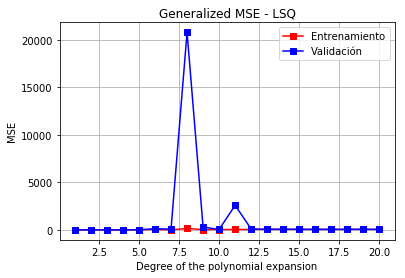

In [22]:
min_degree = 1
max_degree = 20
folds = 10
alpha = 0.0
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 0)

#### b) Regresión aplicando regularización L1 y L2

Hacemos lo propio para los modelos obtenidos usando regresión por mínimos cuadrados usando la norma L1, probando para 5 distintos valores del término de regularización. Evitamos usar valores de alpha menores que 0.0001 debido a que el algoritmo tiene problemas de convergencia. Conviene aquí mencionar que la solución de la ecuación de mínimos cuadrados con regularización L1 no tiene forma cerrada, por lo que la clase _Lasso_ emplea un método númerico de descenso de gradiente para minimizar el error entre predicciones y etiquetas.

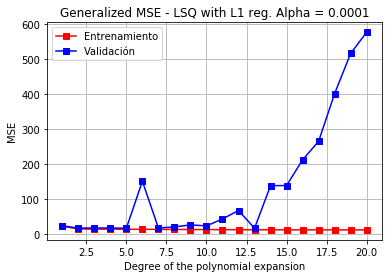

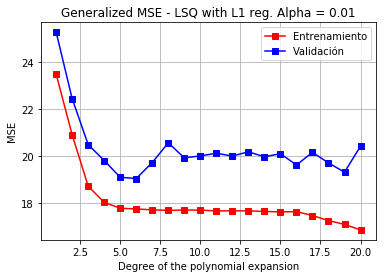

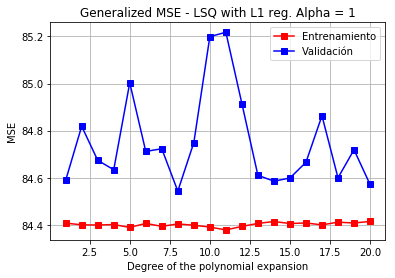

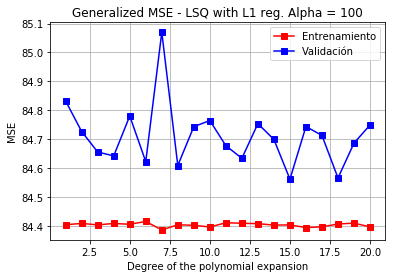

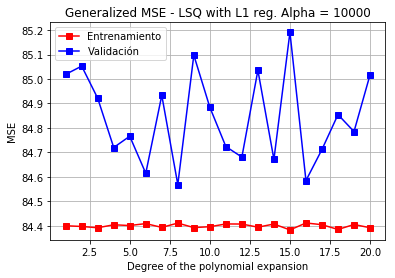

In [24]:
# Linear regression using L1 regularization
alpha = 0.0001
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 1)
alpha = 0.01
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 1)
alpha = 1
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 1)
alpha = 100
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 1)
alpha = 10000
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 1)

A continuación hacemos lo mismo para los modelos entrenados por mínimos cuadrados con regularización por norma L2.

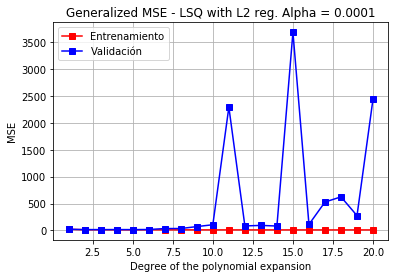

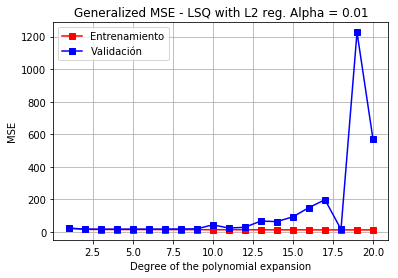

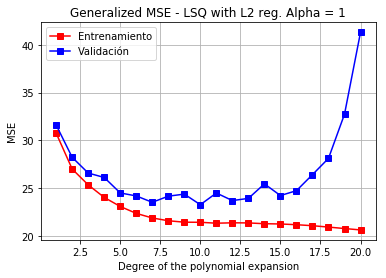

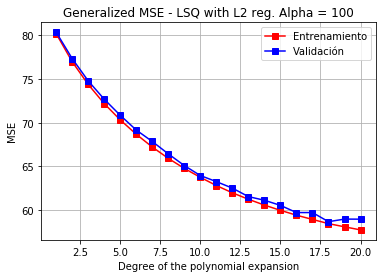

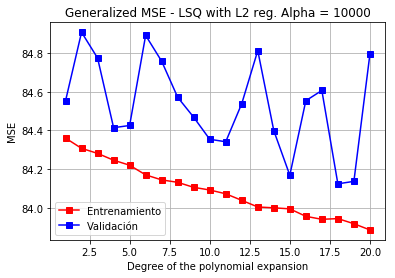

In [25]:
alpha = 0.0001
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 2)
alpha = 0.01
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 2)
alpha = 1
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 2)
alpha = 100
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 2)
alpha = 10000
run_model_with_cv(houses, folds, alpha, min_degree, max_degree, 2)

De las gráficas anteriores, podemos observar que los modelos que mejor se comportan son aquellos modelos que usaron un factor de regularización muy pequeño. 


#### c) Selección de los atributos más importantes

La minimización por regla L1, o _Lasso_, penaliza el tamaño absoluto de los coeficientes de regresión. Al hacer esto, _Lasso_ puede llevar a que los coeficientes de variables irrelevantes se vayan a 0. Por lo tanto, para seleccionar a nuestros atributos más importantes, obtendremos a un modelo lineal con expansión polinomial de grado 1, usando la minización por regla Lasso, y descartaremos a todos aquellos atributos cuyos parámetros $\theta$ estén, relativamente, más cercanos a cero.

Ya que nuestros datos no están separados en datos de prueba y datos de validación, los separaremos con ayuda de la función _train-test-split_. A partir de los datos de entrenamiento, entrenaremos a un modelo de regresión lineal, con el objetivo de obtener a nuestro vector de parámetros $\theta$. Son precisamente los valores dentro de este $\theta$ los que utilizaremos para seleccionar a los mejores atributos de entrada.

In [55]:
from sklearn.model_selection import train_test_split as tts
training_data, test_data = tts(houses, test_size=0.30)

Xt = training_data[:, :-1]
Yt = training_data[:, -1]
Xv = test_data[:, :-1]
Yv = test_data[:, -1]

regularized_lsq_l1(Xt, Yt, 0.0001, 1)

array([[ 3.23113667e+01],
       [-1.26541005e-01],
       [ 4.93824610e-02],
       [ 1.13175218e-02],
       [ 3.51171449e+00],
       [-1.53921967e+01],
       [ 3.97726169e+00],
       [-3.92520876e-03],
       [-1.47871974e+00],
       [ 3.26580616e-01],
       [-1.06036392e-02],
       [-8.58711329e-01],
       [ 9.66357463e-03],
       [-5.96255014e-01]])

De los parámetros anteriores, podemos observar que los parámetros mas lejanos de 0 son los que corresponden a los atributos 1 (tasa de crimen per cápita), 6 (número de habitaciones), 7 (antigüedad de las construcciones) y 9 (accesibilidad a vías vehiculares radiales). Por lo tanto, seleccionamos a estos atributos como los atributos más importantes, los ubicamos dentro de una nueva matriz de entradas $X_{tt}$, y revisamos su desempeño. Usaremos el mejor término de regularización encontrado hasta ahora (0.0001) y norma L1 para la construcción de estos modelos:

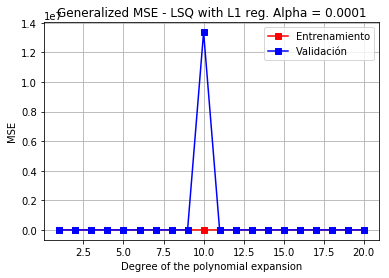

In [56]:
Xtt = np.column_stack((Xt[:,0], Xt[:,5], Xt[:,6], Xt[:,8]))
curated_data = np.column_stack((Xtt, Yt))
alpha = 0.0001
run_model_with_cv(curated_data, folds, alpha, min_degree, max_degree, 1)

Observamos que el desempeño general de los modelos, usando sólo estos atributos de entrada, es muy superior al de los modelos entrenados con todos los atributos de entrada, para un mismo parámetro de regularización, usando L1. Prácticamente todos los modelos observan un $MSE$ muy cercano a cero. Esto nos sugiere que los parámetros elegidos, están muy correlacionados positivamente, aparentemente de forma estadísticamente significativa, con el precio de las casas en Boston.